# This code is for analysing the data within our dataset to investigate relationships between our variables.

First we set up the CSV we will be working on

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

plt.style.use('default')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

print("Starting Fraud Detection EDA...")
print("="*50)

file_path = "../bbd-payments-hackathon-2025/Payments Fraud DataSet/"
customers_df = pd.read_csv(file_path + "customers.csv")
merchants_df = pd.read_csv(file_path + "merchants.csv")
terminals_df = pd.read_csv(file_path + "terminals.csv")
transactions_df = pd.read_csv(file_path + "transactions_train.csv")

merged_df = transactions_df.copy()
merged_df = merged_df.merge(customers_df, on='CUSTOMER_ID', how='left')
merged_df = merged_df.merge(terminals_df, on='TERMINAL_ID', how='left')
merged_df = merged_df.merge(merchants_df, on='MERCHANT_ID', how='left')

merged_df.columns = merged_df.columns.str.upper()

print(merged_df.head())


Starting Fraud Detection EDA...
                                      TX_ID                      TX_TS  \
0  c6dde46458f3d1cfeb9256f8add45a14fb349f8f  2021-04-02 12:42:24+00:00   
1  ddd7cafa71ee84f3b46498fb6aa9f92450116719  2021-02-06 15:16:01+00:00   
2  fe42708ae41a8f25259b96c25e2d6067568c224c  2021-05-15 08:10:51+00:00   
3  c3c6ffdc73d71f35c0da72032420e15289e4d073  2021-02-02 11:12:29+00:00   
4  ced166cbbafcf3dc10fa369472253c986b12b6f8  2021-01-07 00:17:46+00:00   

        CUSTOMER_ID  TERMINAL_ID  TX_AMOUNT  TX_FRAUD  \
0  7323088226725338     55875360       0.00         0   
1  8627200351202456     31418810       1.14         0   
2  8983139483148479     84302882       0.46         0   
3  2016744441942099     26364082       2.06         0   
4  6888146658050582     34582161       1.50         0   

   TRANSACTION_GOODS_AND_SERVICES_AMOUNT  TRANSACTION_CASHBACK_AMOUNT  \
0                                   0.00                          0.0   
1                                 

How much fraud is in the dataset?

Total transactions: 1,066,439
Legitimate transactions: 1,038,875 (97.42%)
Fraudulent transactions: 27,564 (2.58%)



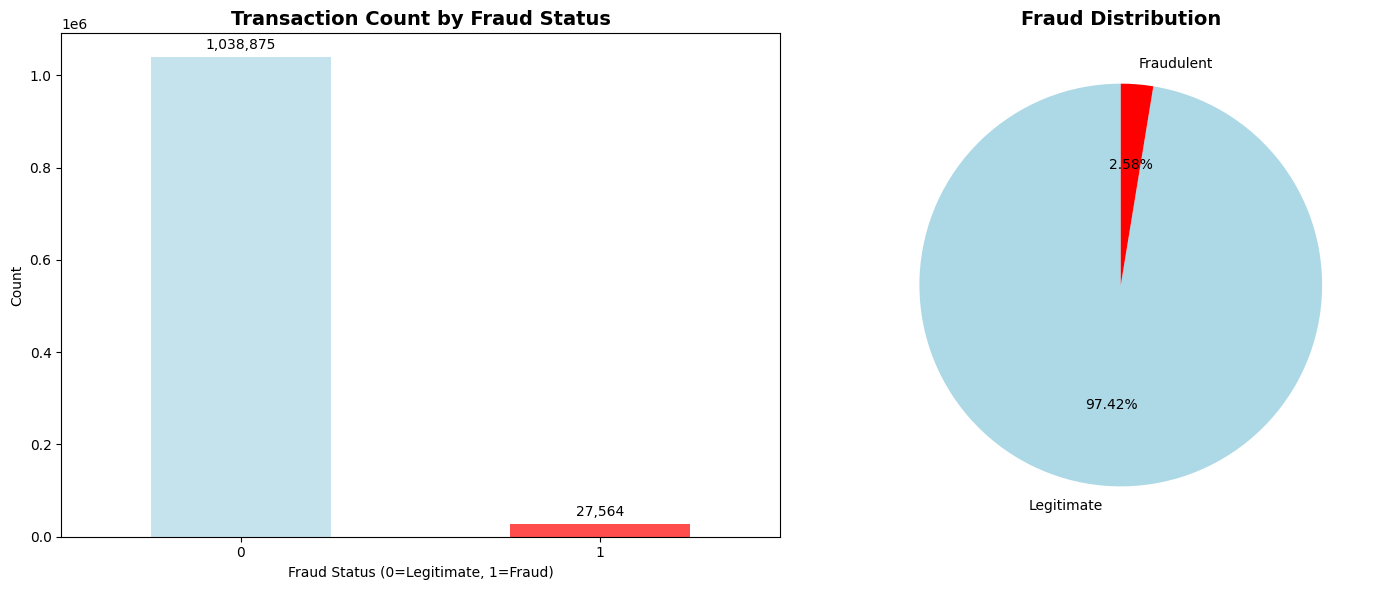

In [28]:
fraud_counts = merged_df['TX_FRAUD'].value_counts()
fraud_percentage = merged_df['TX_FRAUD'].value_counts(normalize=True) * 100
print(f"Total transactions: {len(merged_df):,}")
print(f"Legitimate transactions: {fraud_counts[0]:,} ({fraud_percentage[0]:.2f}%)")
print(f"Fraudulent transactions: {fraud_counts[1]:,} ({fraud_percentage[1]:.2f}%)")
print()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Bar chart
fraud_counts.plot(kind='bar', ax=ax1, color=['lightblue', 'red'], alpha=0.7)
ax1.set_title('Transaction Count by Fraud Status', fontsize=14, fontweight='bold')
ax1.set_xlabel('Fraud Status (0=Legitimate, 1=Fraud)')
ax1.set_ylabel('Count')
ax1.tick_params(axis='x', rotation=0)

for i, v in enumerate(fraud_counts.values):
    ax1.text(i, v + len(merged_df)*0.01, f'{v:,}', ha='center', va='bottom')

# Pie chart
ax2.pie(fraud_counts.values, labels=['Legitimate', 'Fraudulent'], 
        colors=['lightblue', 'red'], autopct='%1.2f%%', startangle=90)
ax2.set_title('Fraud Distribution', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

We can see in the above figure that the dataset is only 2.58% fraud. This is a highly class imbalanced datset: the number of negative cases is greatly outnumbering the number of positive cases of fraud. 

Let's look more closely into the features.
Specifically, where is fraud happening in terms of customers and terminals?

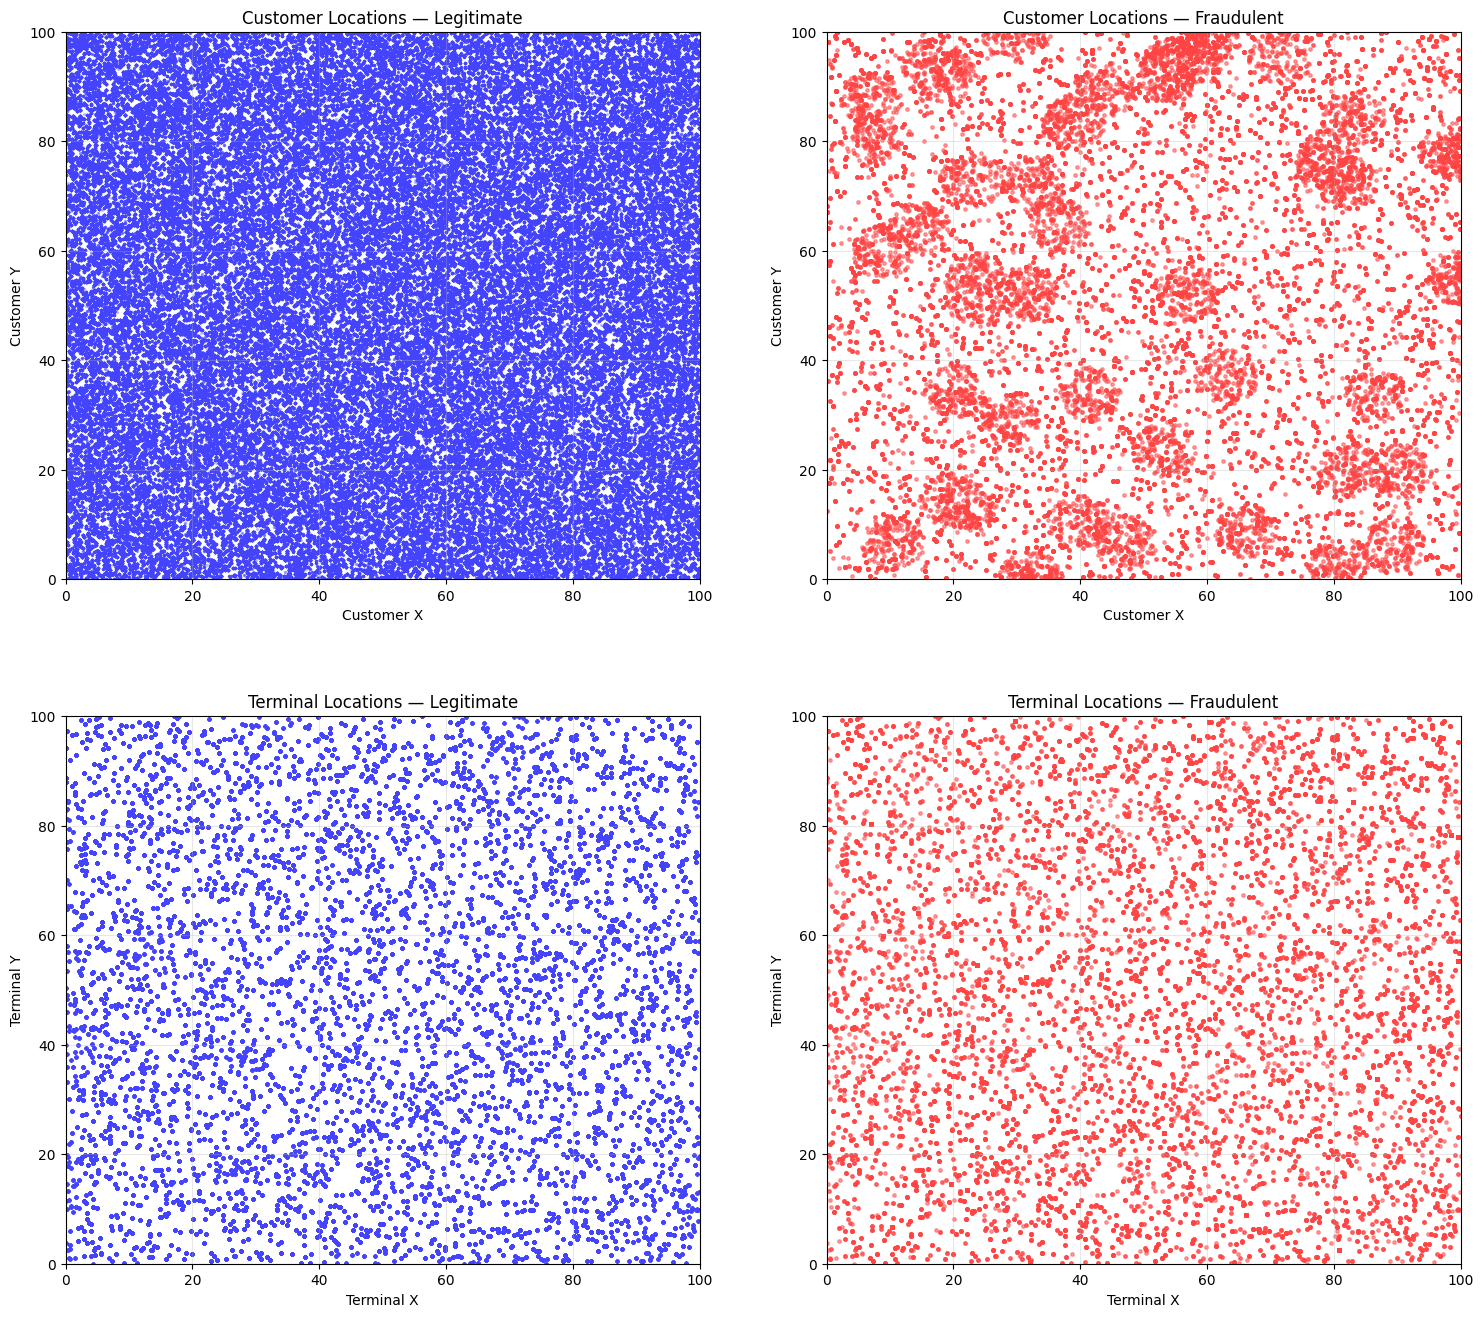

In [29]:
# Split data by fraud label
fraud_data = merged_df[merged_df['TX_FRAUD'] == 1].copy()
legit_data = merged_df[merged_df['TX_FRAUD'] == 0].copy()

# Select coordinates using correct column selection (lists) and uppercase names
customer_coords_legit = legit_data[["X_CUSTOMER_ID", "Y_CUSTOMER_ID"]].dropna()
customer_coords_fraud = fraud_data[["X_CUSTOMER_ID", "Y_CUSTOMER_ID"]].dropna()
terminal_coords_legit = legit_data[["X_TERMINAL_ID", "Y_TERMINAL_ID"]].dropna()
terminal_coords_fraud = fraud_data[["X_TERMINAL_ID", "Y_TERMINAL_ID"]].dropna()

# Create 2x2 grid: customers (legit, fraud) and terminals (legit, fraud)
fig, axes = plt.subplots(2, 2, figsize=(18, 16))
plt.subplots_adjust(hspace=0.25, wspace=0.2)

fraud_color = '#FF4444'
legitimate_color = '#4444FF'

# Customers - Legitimate
ax = axes[0, 0]
ax.scatter(customer_coords_legit["X_CUSTOMER_ID"], customer_coords_legit["Y_CUSTOMER_ID"],
           c=legitimate_color, alpha=0.25, s=2, label=f'Legitimate ({len(customer_coords_legit):,})')
ax.set_xlabel('Customer X')
ax.set_ylabel('Customer Y')
ax.set_title('Customer Locations — Legitimate')
ax.grid(True, alpha=0.3)
ax.set_xlim(0, 100)
ax.set_ylim(0, 100)

# Customers - Fraudulent
ax = axes[0, 1]
ax.scatter(customer_coords_fraud["X_CUSTOMER_ID"], customer_coords_fraud["Y_CUSTOMER_ID"],
           c=fraud_color, alpha=0.5, s=6, label=f'Fraudulent ({len(customer_coords_fraud):,})')
ax.set_xlabel('Customer X')
ax.set_ylabel('Customer Y')
ax.set_title('Customer Locations — Fraudulent')
ax.grid(True, alpha=0.3)
ax.set_xlim(0, 100)
ax.set_ylim(0, 100)

# Terminals - Legitimate
ax = axes[1, 0]
ax.scatter(terminal_coords_legit["X_TERMINAL_ID"], terminal_coords_legit["Y_TERMINAL_ID"],
           c=legitimate_color, alpha=0.25, s=2, label=f'Legitimate ({len(terminal_coords_legit):,})')
ax.set_xlabel('Terminal X')
ax.set_ylabel('Terminal Y')
ax.set_title('Terminal Locations — Legitimate')
ax.grid(True, alpha=0.3)
ax.set_xlim(0, 100)
ax.set_ylim(0, 100)

# Terminals - Fraudulent
ax = axes[1, 1]
ax.scatter(terminal_coords_fraud["X_TERMINAL_ID"], terminal_coords_fraud["Y_TERMINAL_ID"],
           c=fraud_color, alpha=0.5, s=6, label=f'Fraudulent ({len(terminal_coords_fraud):,})')
ax.set_xlabel('Terminal X')
ax.set_ylabel('Terminal Y')
ax.set_title('Terminal Locations — Fraudulent')
ax.grid(True, alpha=0.3)
ax.set_xlim(0, 100)
ax.set_ylim(0, 100)

plt.show()

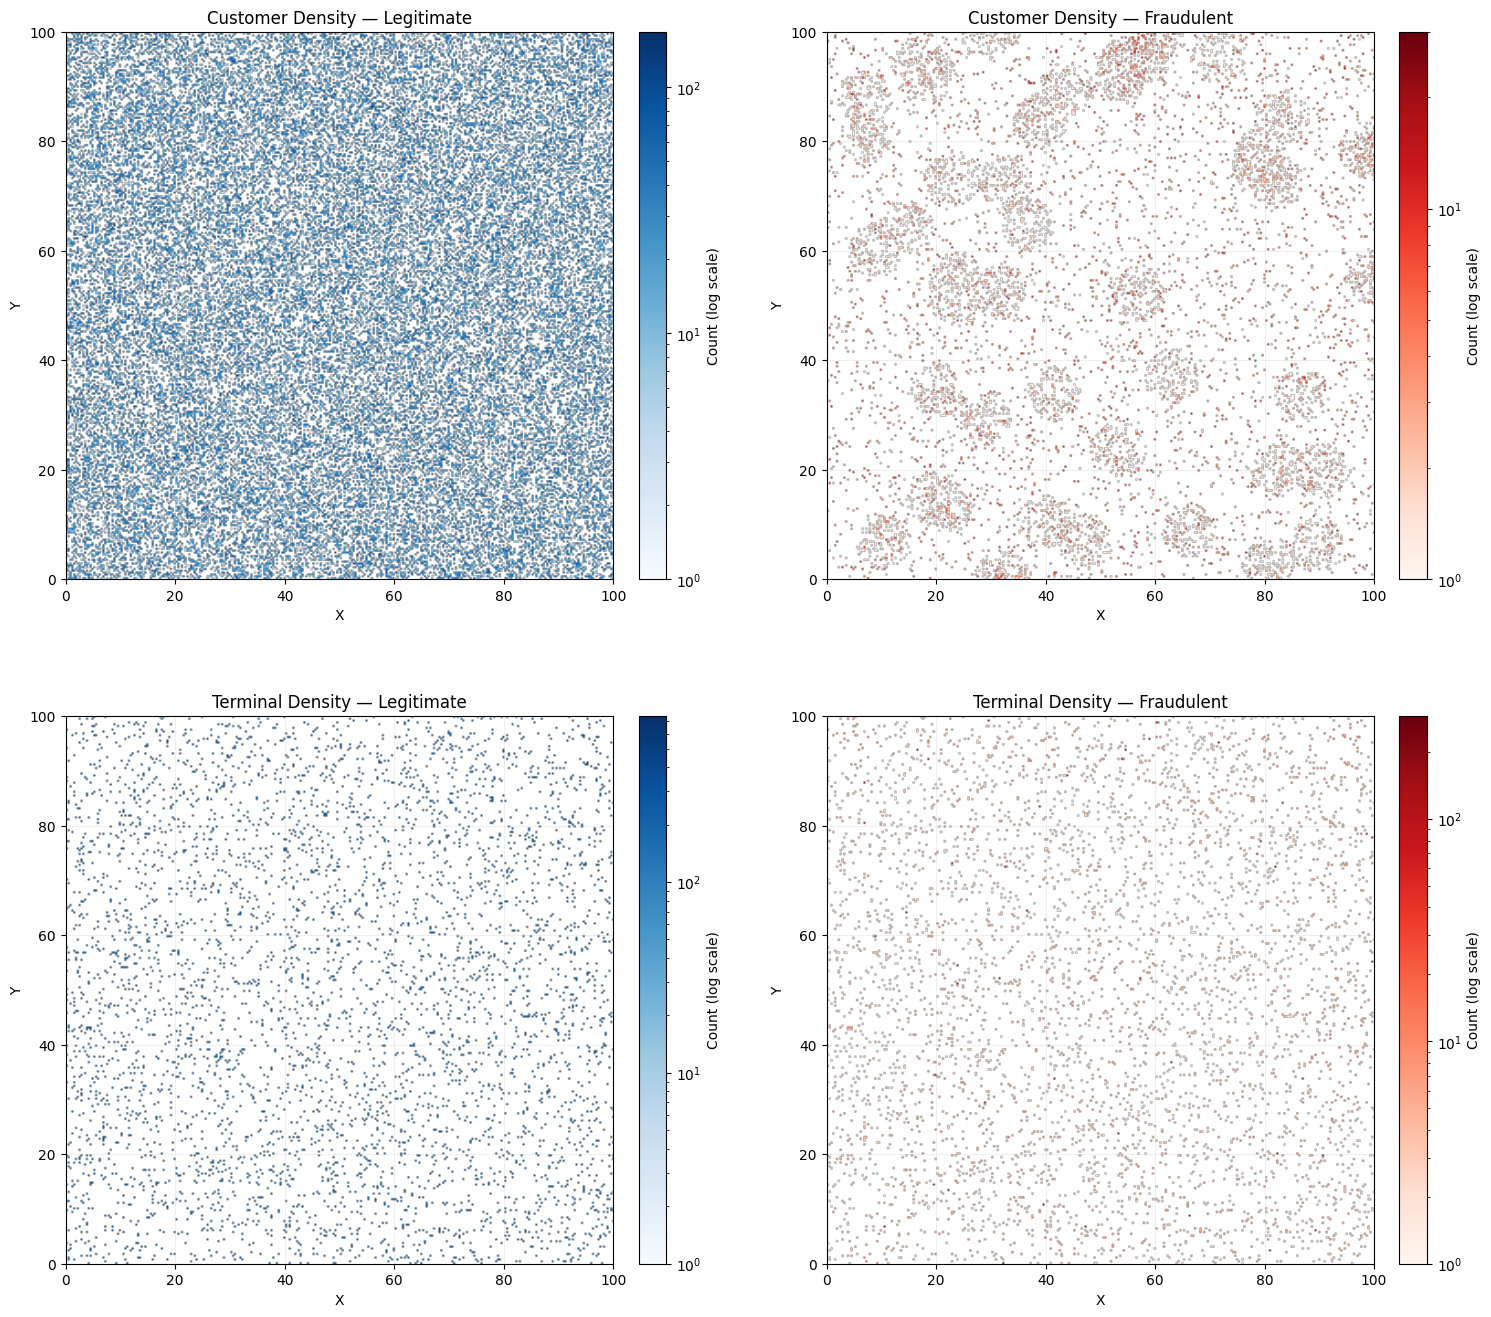

In [30]:
# Heatmap versions (2D histograms) for customers and terminals by fraud status
import numpy as np
from matplotlib.colors import LogNorm

# Helper to plot a 2D histogram heatmap on [0,100]x[0,100]
def plot_heatmap(ax, x_values, y_values, title, cmap):
    # Ensure numpy arrays
    x = np.asarray(x_values)
    y = np.asarray(y_values)
    # Clip to grid bounds to avoid out-of-range bins
    x = np.clip(x, 0, 100)
    y = np.clip(y, 0, 100)
    # 2D histogram (finer grid)
    H, xedges, yedges = np.histogram2d(x, y, bins=300, range=[[0, 100], [0, 100]])
    # Avoid zero-only norm
    vmax = max(1, H.max())
    img = ax.imshow(
        H.T,
        origin='lower',
        extent=[0, 100, 0, 100],
        cmap=cmap,
        norm=LogNorm(vmin=1, vmax=vmax),
        interpolation='bilinear'
    )
    ax.set_xlim(0, 100)
    ax.set_ylim(0, 100)
    ax.set_title(title)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.grid(True, alpha=0.2)
    return img

fig, axes = plt.subplots(2, 2, figsize=(18, 16))
plt.subplots_adjust(hspace=0.25, wspace=0.2)

# Customers — Legitimate (Blues)
img = plot_heatmap(
    axes[0, 0],
    customer_coords_legit["X_CUSTOMER_ID"],
    customer_coords_legit["Y_CUSTOMER_ID"],
    'Customer Density — Legitimate',
    cmap='Blues'
)
plt.colorbar(img, ax=axes[0, 0], fraction=0.046, pad=0.04, label='Count (log scale)')

# Customers — Fraudulent (Reds)
img = plot_heatmap(
    axes[0, 1],
    customer_coords_fraud["X_CUSTOMER_ID"],
    customer_coords_fraud["Y_CUSTOMER_ID"],
    'Customer Density — Fraudulent',
    cmap='Reds'
)
plt.colorbar(img, ax=axes[0, 1], fraction=0.046, pad=0.04, label='Count (log scale)')

# Terminals — Legitimate (Blues)
img = plot_heatmap(
    axes[1, 0],
    terminal_coords_legit["X_TERMINAL_ID"],
    terminal_coords_legit["Y_TERMINAL_ID"],
    'Terminal Density — Legitimate',
    cmap='Blues'
)
plt.colorbar(img, ax=axes[1, 0], fraction=0.046, pad=0.04, label='Count (log scale)')

# Terminals — Fraudulent (Reds)
img = plot_heatmap(
    axes[1, 1],
    terminal_coords_fraud["X_TERMINAL_ID"],
    terminal_coords_fraud["Y_TERMINAL_ID"],
    'Terminal Density — Fraudulent',
    cmap='Reds'
)
plt.colorbar(img, ax=axes[1, 1], fraction=0.046, pad=0.04, label='Count (log scale)')

plt.show()


There is clearly a pattern amongst the fraudulent customers... people who commit fraud tend to be grouped around each other. Or Rather, instances of fraud tend to happen around the same area. This information will be important when creating the model

Lets try get a correlation matrix happening here

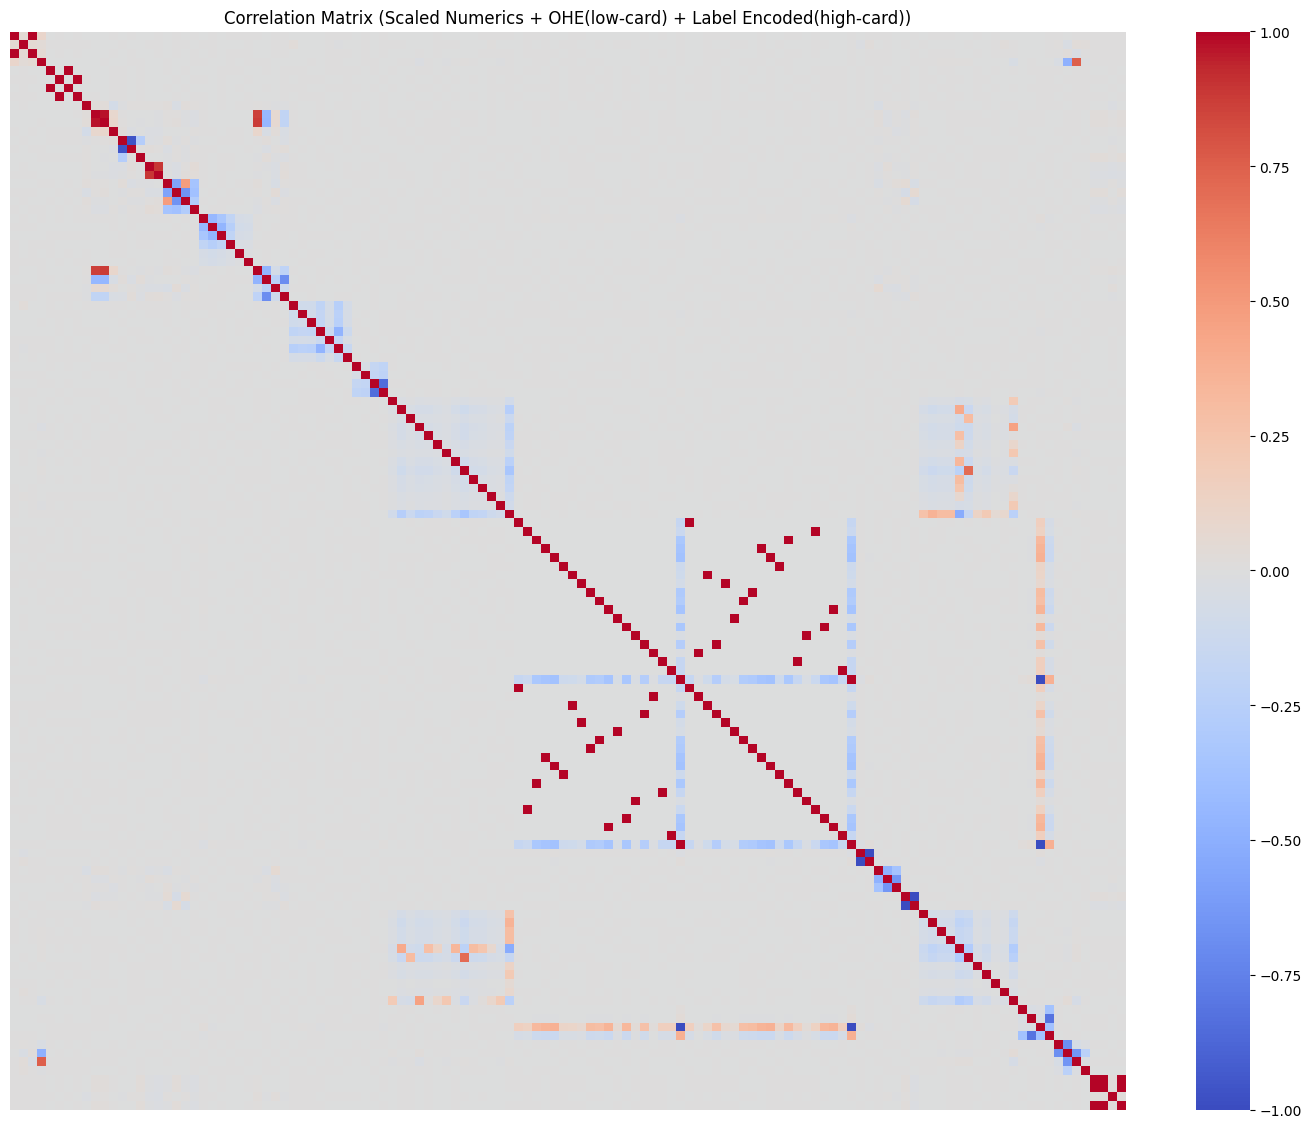

TX_AMOUNT                                                      0.052212
TRANSACTION_GOODS_AND_SERVICES_AMOUNT                          0.050814
TRANSACTION_TYPE_Purchase                                      0.035326
TRANSACTION_CASHBACK_AMOUNT                                    0.031400
TRANSACTION_TYPE_Purchase with cashback                        0.030575
CARDHOLDER_AUTH_METHOD_No CVM performed                        0.029640
TRANSACTION_CURRENCY_RON                                       0.022655
IS_RECURRING_TRANSACTION_True                                  0.020228
IS_RECURRING_TRANSACTION_False                                 0.020228
TRANSACTION_TYPE_Refund                                        0.016591
TRANSACTION_TYPE_Cash Advance/Withdrawal                       0.013910
CARD_COUNTRY_CODE_RO                                           0.009632
CARDHOLDER_AUTH_METHOD_Online PIN                              0.009143
Y_CUSTOMER_ID                                                  0

In [31]:
# Memory-safe encoding + scaling for correlation matrix
import numpy as np
import pandas as pd
from sklearn.preprocessing import OneHotEncoder, RobustScaler

# Work from merged_df, drop identifiers
id_cols = ['TX_ID', 'TX_TS', 'MERCHANT_ID', 'CUSTOMER_ID', 'TERMINAL_ID', 'CARD_DATA', 'CARD_EXPIRY_DATE']
df = merged_df.drop(columns=[c for c in id_cols if c in merged_df.columns]).copy()

# Identify base categorical columns
categorical_base = df.select_dtypes(include=['object', 'category', 'bool']).columns.tolist()
# Treat low-unique numeric as categorical (excluding target)
low_unique_numeric = [c for c in df.select_dtypes(include=[np.number]).columns
                      if c != 'TX_FRAUD' and df[c].nunique(dropna=True) < 10]
categorical_cols = sorted(set(categorical_base + low_unique_numeric))

# Split by cardinality to avoid massive one-hot expansions
cardinality_threshold = 30
col_nunique = {c: df[c].nunique(dropna=True) for c in categorical_cols}
low_card_cols = [c for c in categorical_cols if col_nunique[c] <= cardinality_threshold]
high_card_cols = [c for c in categorical_cols if col_nunique[c] > cardinality_threshold]

# Numerics (exclude anything we will encode as categorical)
numeric_cols = [c for c in df.select_dtypes(include=[np.number]).columns if c not in categorical_cols]

# One-hot encode low-card categoricals (dense but small)
if len(low_card_cols) > 0:
    ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore', dtype=np.float32)
    encoded = ohe.fit_transform(df[low_card_cols])
    encoded_df = pd.DataFrame(encoded, columns=ohe.get_feature_names_out(low_card_cols), index=df.index)
else:
    encoded_df = pd.DataFrame(index=df.index)

# Label-encode high-card categoricals using factorize (memory-light, deterministic order)
high_card_df = pd.DataFrame(index=df.index)
for c in high_card_cols:
    codes, uniques = pd.factorize(df[c].astype(str), sort=True)
    # Use int32; -1 for NaN will be represented as -1 if present
    high_card_df[c] = pd.Series(codes, index=df.index, dtype=np.int32)

# Scale numerics with RobustScaler and cast to float32
scaler = RobustScaler()
if len(numeric_cols) > 0:
    scaled_numeric = scaler.fit_transform(df[numeric_cols])
    scaled_numeric_df = pd.DataFrame(scaled_numeric, columns=numeric_cols, index=df.index, dtype=np.float32)
else:
    scaled_numeric_df = pd.DataFrame(index=df.index)

# Combine all
processed_df = pd.concat([scaled_numeric_df, encoded_df.astype(np.float32), high_card_df], axis=1)

# Ensure TX_FRAUD is present as numeric for correlation
if 'TX_FRAUD' in df.columns and 'TX_FRAUD' not in processed_df.columns:
    processed_df['TX_FRAUD'] = df['TX_FRAUD'].astype(np.float32)

# Optional: downcast everything possible
for col in processed_df.select_dtypes(include=['float64']).columns:
    processed_df[col] = processed_df[col].astype(np.float32)

# To avoid huge memory in correlation, optionally sample rows if extremely wide
max_rows_for_corr = 300_000
df_for_corr = processed_df
if processed_df.shape[0] > max_rows_for_corr:
    df_for_corr = processed_df.sample(n=max_rows_for_corr, random_state=42)

# Compute correlation matrix
corr = df_for_corr.corr()

# Plot
plt.figure(figsize=(18, 14))
sns.heatmap(corr, cmap='coolwarm', center=0, square=False, xticklabels=False, yticklabels=False)
plt.title('Correlation Matrix (Scaled Numerics + OHE(low-card) + Label Encoded(high-card))')
plt.show()

# Show top correlations with TX_FRAUD
if 'TX_FRAUD' in corr.columns:
    top_corr = corr['TX_FRAUD'].drop('TX_FRAUD').abs().sort_values(ascending=False).head(25)
    display(top_corr)


OK the correlation matrix is struggling. We have so many features and so many categorical features that it is struggling to find the explicit correlations between them. These hot spots are artifacts from the encoding and the relationships are likely not linear.